# 0.0 Imports

In [50]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import inflection

from scipy                import stats as ss
from matplotlib           import pyplot as plt
from IPython.core.display import HTML
from IPython.core.display import Image

### 0.1 Helper Functions

In [117]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) ) 
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def jupyter_settings(): 
    %matplotlib inline 
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [24, 20]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') ) 
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 1000
    pd.set_option( 'display.expand_frame_repr', False ) 
    sns.set()
    
def fahr_to_celsius(temp_fahr):
    temp_celsius = (temp_fahr - 32) * 5 / 9
    return temp_celsius
    
jupyter_settings()   

Populating the interactive namespace from numpy and matplotlib


### 0.2 Loading Data

In [11]:
df_train_raw = pd.read_csv('data/train.csv', low_memory=False)
df_features_raw = pd.read_csv('data/features.csv', low_memory=False)
df_store_raw = pd.read_csv('data/stores.csv', low_memory=False)

#merge
features_raw = df_features_raw.merge(df_store_raw, on='Store', how='inner')
df_raw = df_train_raw.merge(features_raw, on=['Store', 'Date', 'IsHoliday'], how='inner')

In [12]:
df_raw.sample()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
273999,28,23,2011-12-30,34659.26,True,44.64,3.428,5218.93,49826.06,155.37,1011.54,7761.98,130.071032,12.89,A,206302


# 1.0 Descrição Dos Dados

In [13]:
df1 = df_raw.copy()

In [14]:
df1.columns

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')

### 1.1 Rename Columns

In [15]:
cols_old = ['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map (snakecase, cols_old))

#rename
df1.columns = cols_new

In [16]:
df1.sample()

,store,dept,date,weekly_sales,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,type,size
93520,10,56,2011-09-02,723.4,False,91.61,3.798,NaN,NaN,NaN,NaN,NaN,129.325936,8.257,B,126512


### 1.2 Data Dimensions

In [17]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 421570
Number of Cols: 16


### 1.3 Data Types

In [18]:
df1.dtypes

store             int64
dept              int64
date             object
weekly_sales    float64
is_holiday         bool
temperature     float64
fuel_price      float64
mark_down1      float64
mark_down2      float64
mark_down3      float64
mark_down4      float64
mark_down5      float64
cpi             float64
unemployment    float64
type             object
size              int64
dtype: object

### 1.4 Check NA

In [19]:
df1.isna().sum()

store                0
dept                 0
date                 0
weekly_sales         0
is_holiday           0
temperature          0
fuel_price           0
mark_down1      270889
mark_down2      310322
mark_down3      284479
mark_down4      286603
mark_down5      270138
cpi                  0
unemployment         0
type                 0
size                 0
dtype: int64

### 1.5 Fillout NA

In [20]:
#mark_down1      270889
df1['mark_down1'] = df1['mark_down1'].fillna(df1['mark_down1'].mean())
#df1['mark_down1'].apply(lambda x: x.fillna(x.mean()), axis=0)

#mark_down2      310322
df1['mark_down2'] = df1['mark_down2'].fillna(df1['mark_down2'].mean())

#mark_down3      284479
df1['mark_down3'] = df1['mark_down3'].fillna(df1['mark_down3'].mean())

#mark_down4      286603
df1['mark_down4'] = df1['mark_down4'].fillna(df1['mark_down5'].mean())

#mark_down5      270138
df1['mark_down5'] = df1['mark_down5'].fillna(df1['mark_down5'].mean())


In [21]:
df1.sample(5)

,store,dept,date,weekly_sales,is_holiday,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,type,size
299077,31,56,2011-07-15,594.87,False,91.05,3.575,7246.420196,3334.628621,1439.421384,4628.975079,4628.975079,215.013443,7.852,A,203750
302621,31,46,2012-06-29,29114.13,False,88.05,3.286,5659.290000,7.600000,1439.421384,408.590000,6001.910000,221.481334,6.891,A,203750
321398,34,97,2010-04-23,16332.56,False,55.04,2.805,7246.420196,3334.628621,1439.421384,4628.975079,4628.975079,126.471333,9.593,A,158114
195643,20,28,2012-04-27,858.84,False,47.64,4.004,2332.340000,2.820000,41.390000,28.040000,3318.170000,214.422306,7.139,A,203742
64434,7,98,2011-08-12,186.58,False,54.56,3.542,7246.420196,3334.628621,1439.421384,4628.975079,4628.975079,194.110502,8.622,B,70713


### 1.6 Change Types

In [22]:
df1.dtypes

store             int64
dept              int64
date             object
weekly_sales    float64
is_holiday         bool
temperature     float64
fuel_price      float64
mark_down1      float64
mark_down2      float64
mark_down3      float64
mark_down4      float64
mark_down5      float64
cpi             float64
unemployment    float64
type             object
size              int64
dtype: object

In [23]:
df1['date'] = pd.to_datetime(df1['date'])
df1['is_holiday'] = df1['is_holiday'].astype('object')

### 1.7 Descriptive Statistical

In [24]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [25]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.000,45.000000,44.000000,22.200546,22.000000,12.785282,0.077763,-1.146503
1,dept,1.000,99.000000,98.000000,44.260317,37.000000,30.492018,0.358223,-1.215571
2,weekly_sales,-4988.940,693099.360000,698088.300000,15981.258123,7612.030000,22711.156583,3.262008,21.491290
3,temperature,-2.060,100.140000,102.200000,60.090059,62.090000,18.447909,-0.321404,-0.635922
4,fuel_price,2.472,4.468000,1.996000,3.361027,3.452000,0.458514,-0.104901,-1.185405
5,mark_down1,0.270,88646.760000,88646.490000,7246.420196,7246.420196,4956.914937,5.589708,54.650395
6,mark_down2,-265.760,104519.540000,104785.300000,3334.628621,3334.628621,4867.488138,10.592147,150.807771
7,mark_down3,-29.100,141630.610000,141659.710000,1439.421384,1439.421384,5487.595084,14.729167,245.117904
8,mark_down4,0.220,67474.850000,67474.630000,4230.125992,4628.975079,3607.477324,7.546457,87.371054
9,mark_down5,135.160,108519.280000,108384.120000,4628.975079,4628.975079,3573.791065,13.631402,305.585755


C:\Users\AMD\anaconda3\envs\walmart_sales_store\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


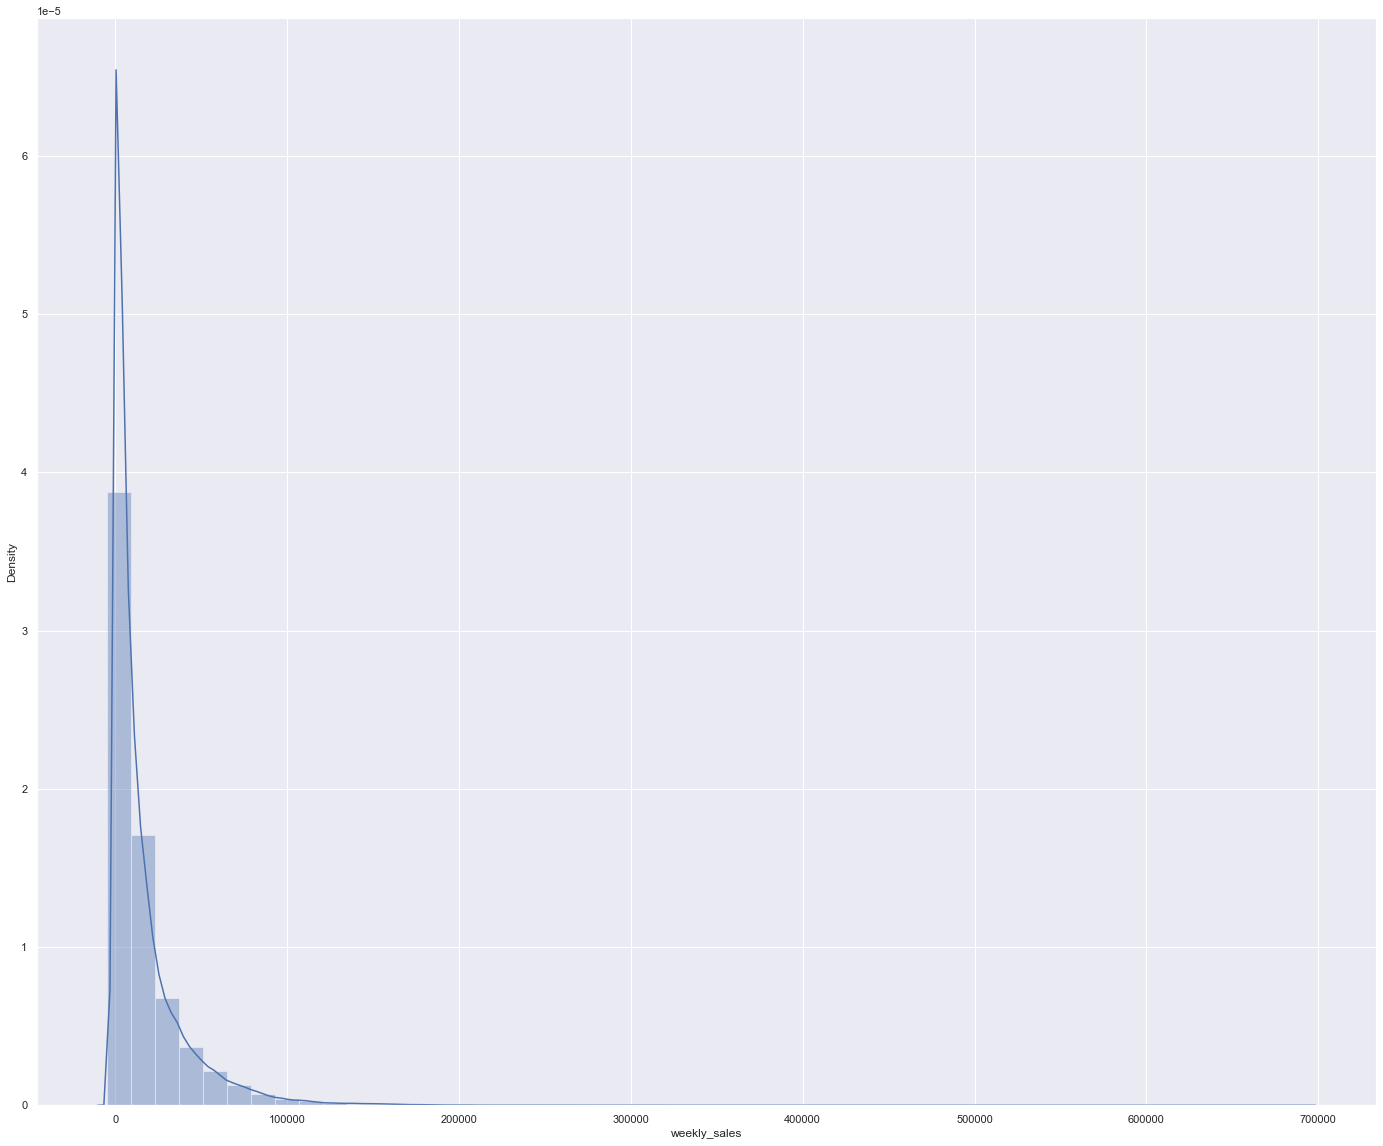

In [26]:
sns.distplot( df1['weekly_sales']);

### 1.7.2 Categorical Attributes

In [27]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

is_holiday    2
type          3
dtype: int64

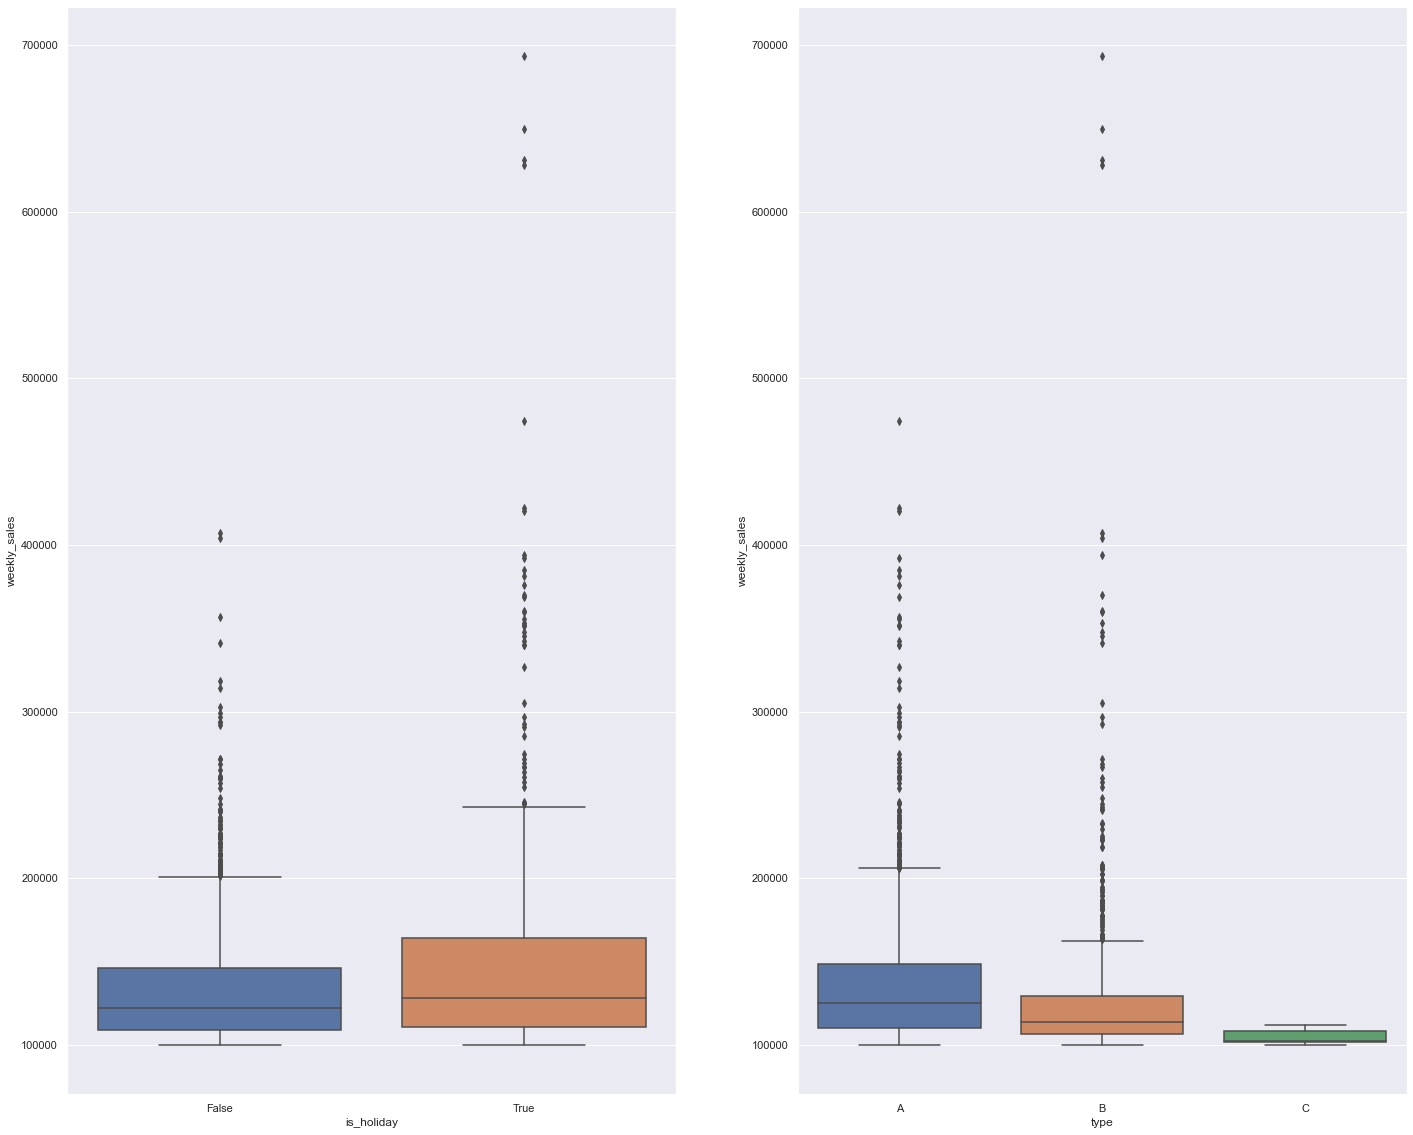

In [28]:
aux1 = df1[df1['weekly_sales'] > 100000]

plt.subplot( 1, 2, 1 );
sns.boxplot( x='is_holiday', y='weekly_sales', data=aux1 ) ;

plt.subplot( 1, 2, 2 );
sns.boxplot( x='type', y='weekly_sales', data=aux1 );

# 2.0 Feature Engineering

In [29]:
df2 = df1.copy()

##  2.1 Mapa mental de Hipoteses

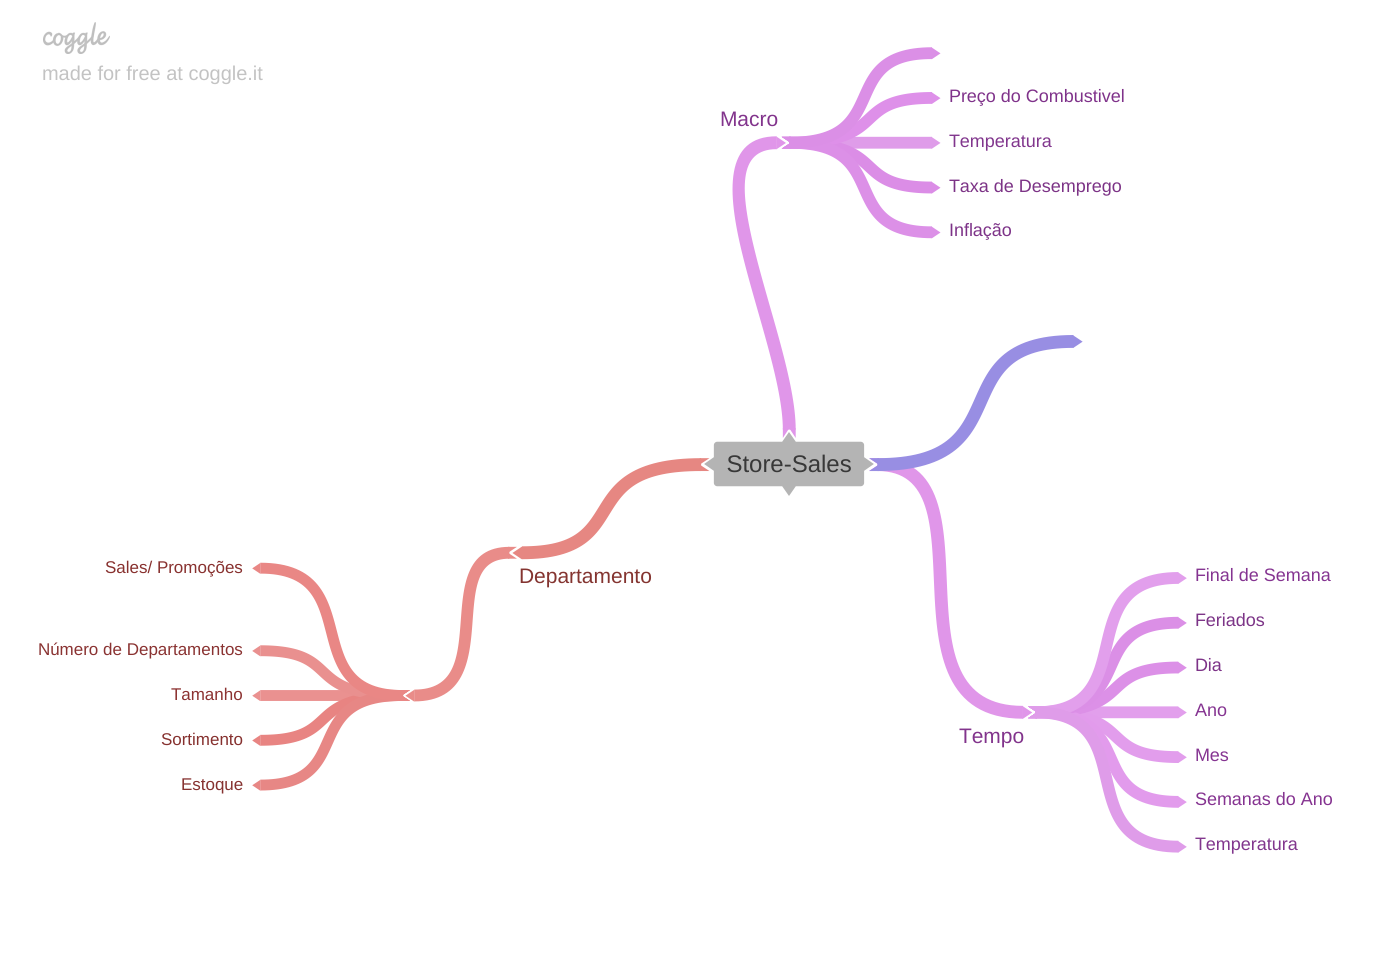

In [30]:
Image('img/MindMapHipothesis_v3.png')

### 2.1 Criação das Hipoteses

### **2.1** Hipotese Loja

**1.** Lojas de maior tamanho deveriam vender mais.

**2.** Lojas com promoções deveriam vender mais

### 2.1 Hipotese Tempo 

**1.** Lojas deveriam vender mais aos finais de semana

**2.** Lojas deveriam vender menos aos feriados

**3.** Lojas vendem mais no primeiro semestre do ano

#### 2.1 Hipotese Macro Ambiente

**H1.** Lojas deveriam vender menos quando o preço do combustivel aumenta.

**H2.** Lojas deveriam vender mais quando a temperatura aumenta.

**H3.** Lojas deveriam vender mais quando o desemprego diminui e a inflação aumenta.

### 2.2 Lista final de Hipoteses

**H1.** Lojas de maior tamanho deveriam vender mais.

**H2.** Lojas com promoções deveriam vender mais


**H3.** Lojas deveriam vender mais aos finais de semana

**H4.** Lojas deveriam vender menos aos feriados

**H5.** Lojas vendem mais no primeiro semestre do ano


**H6.** Lojas deveriam vender menos quando o preço do combustivel aumenta.

**H7.** Lojas deveriam vender mais quando a temperatura aumenta.

**H8.** Lojas deveriam vender mais quando o desemprego diminui e a inflação aumenta.

### 2.3 Feature Engineering

In [31]:
# year
df2['year'] = df2['date'].dt.year
# month
df2['month'] = df2['date'].dt.month
# day
df2['day'] = df2['date'].dt.day
# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear
# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# assortment
df2['type'] = df2['type'].apply(lambda x: 'basic' if x == 'A' else 
                                          'extra' if x == 'B' else 'extended')

#temperature
df2['temperature'] = fahr_to_celsius(df2["temperature"])

C:\Users\AMD\AppData\Local\Temp/ipykernel_6976/1752208883.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0 Filtragem de Variaveis

In [32]:
df3 = df2.copy()

### 3.1 Filtragem das Linha

In [33]:
df3 = df3[df3['weekly_sales'] > 0]

### 3.2 Seleção das Colunas

In [34]:
cols_drop = ['dept']
df3 = df3.drop(cols_drop, axis=1)

In [35]:
df3.columns

Index(['store', 'date', 'weekly_sales', 'is_holiday', 'temperature',
       'fuel_price', 'mark_down1', 'mark_down2', 'mark_down3', 'mark_down4',
       'mark_down5', 'cpi', 'unemployment', 'type', 'size', 'year', 'month',
       'day', 'week_of_year', 'year_week'],
      dtype='object')

# 4.0 Analise Exploratória dos Dados

In [133]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.2 Response  Variable

C:\Users\AMD\anaconda3\envs\walmart_sales_store\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='weekly_sales'>

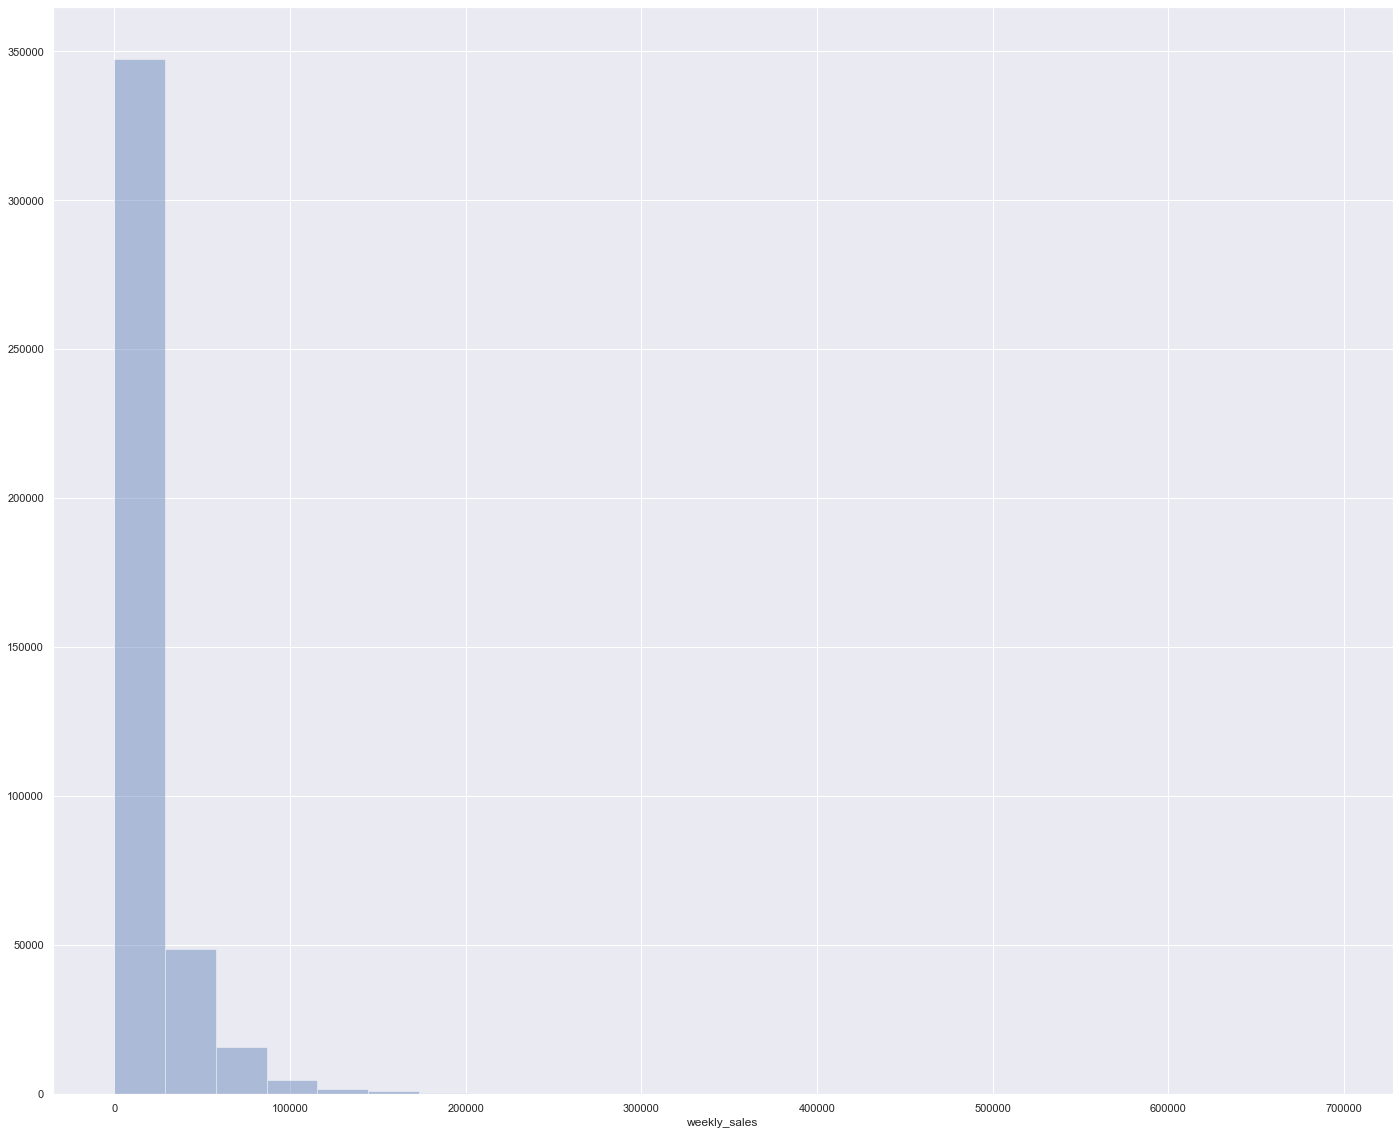

In [134]:
sns.distplot(df4['weekly_sales'] , bins=24, kde= False)

### 4.1.3 Numerical Variables

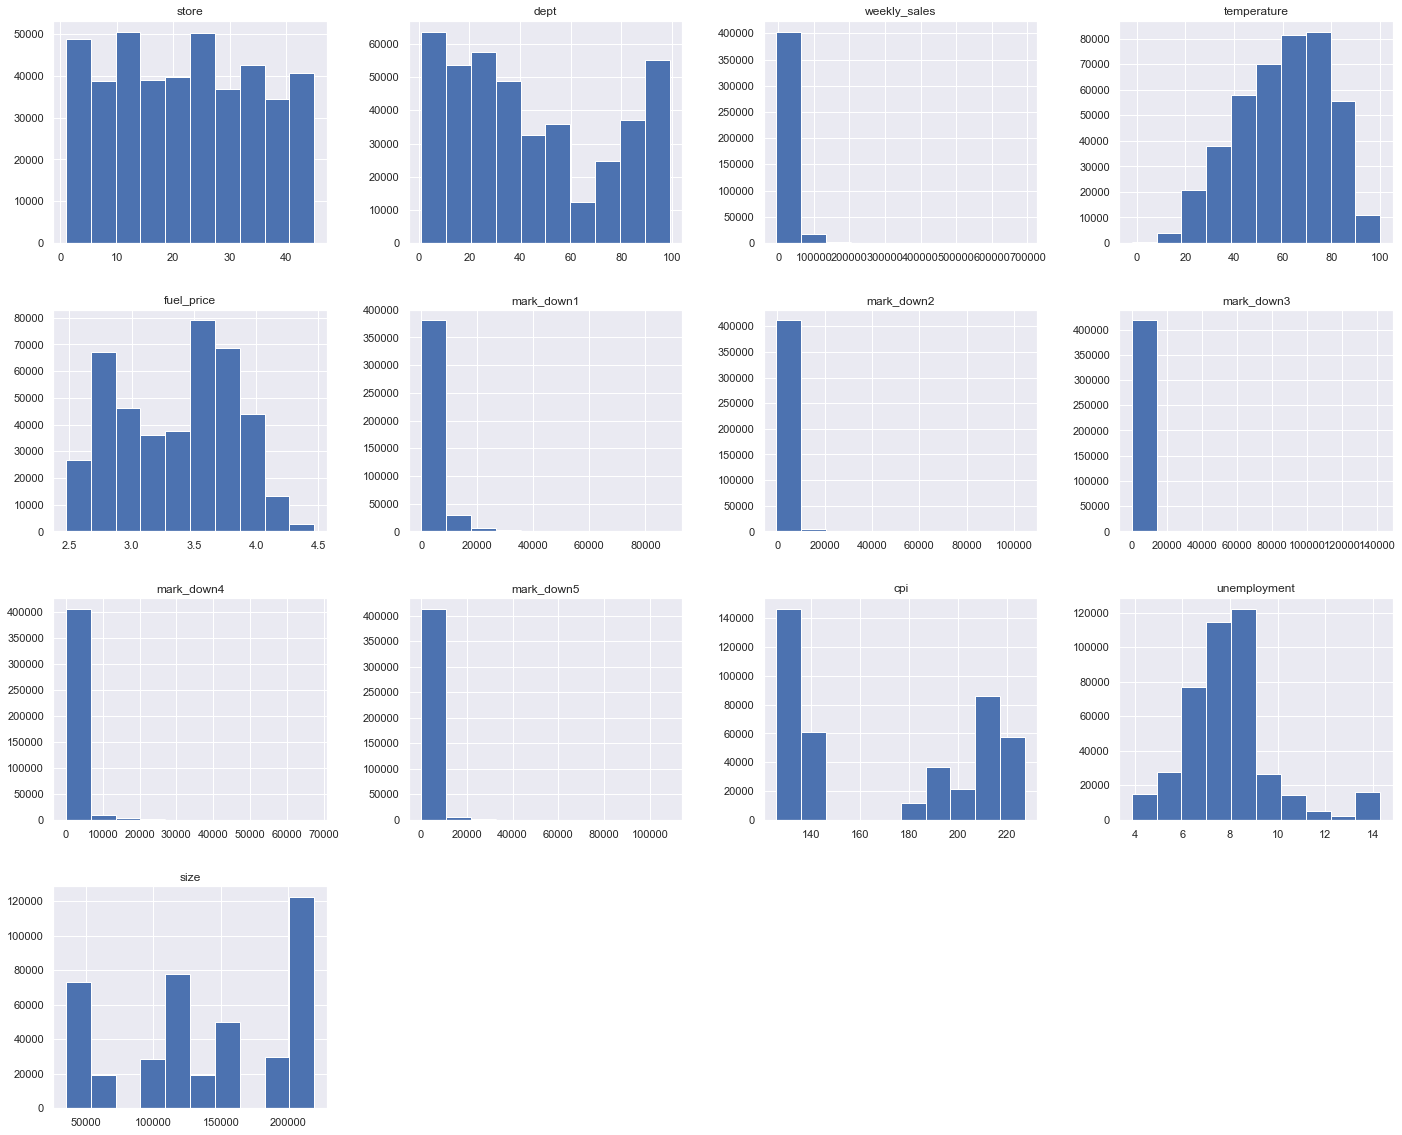

In [135]:
num_attributes.hist();

### 4.1.4 Categorical Variables

C:\Users\AMD\anaconda3\envs\walmart_sales_store\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\AMD\anaconda3\envs\walmart_sales_store\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='is_holiday', ylabel='count'>

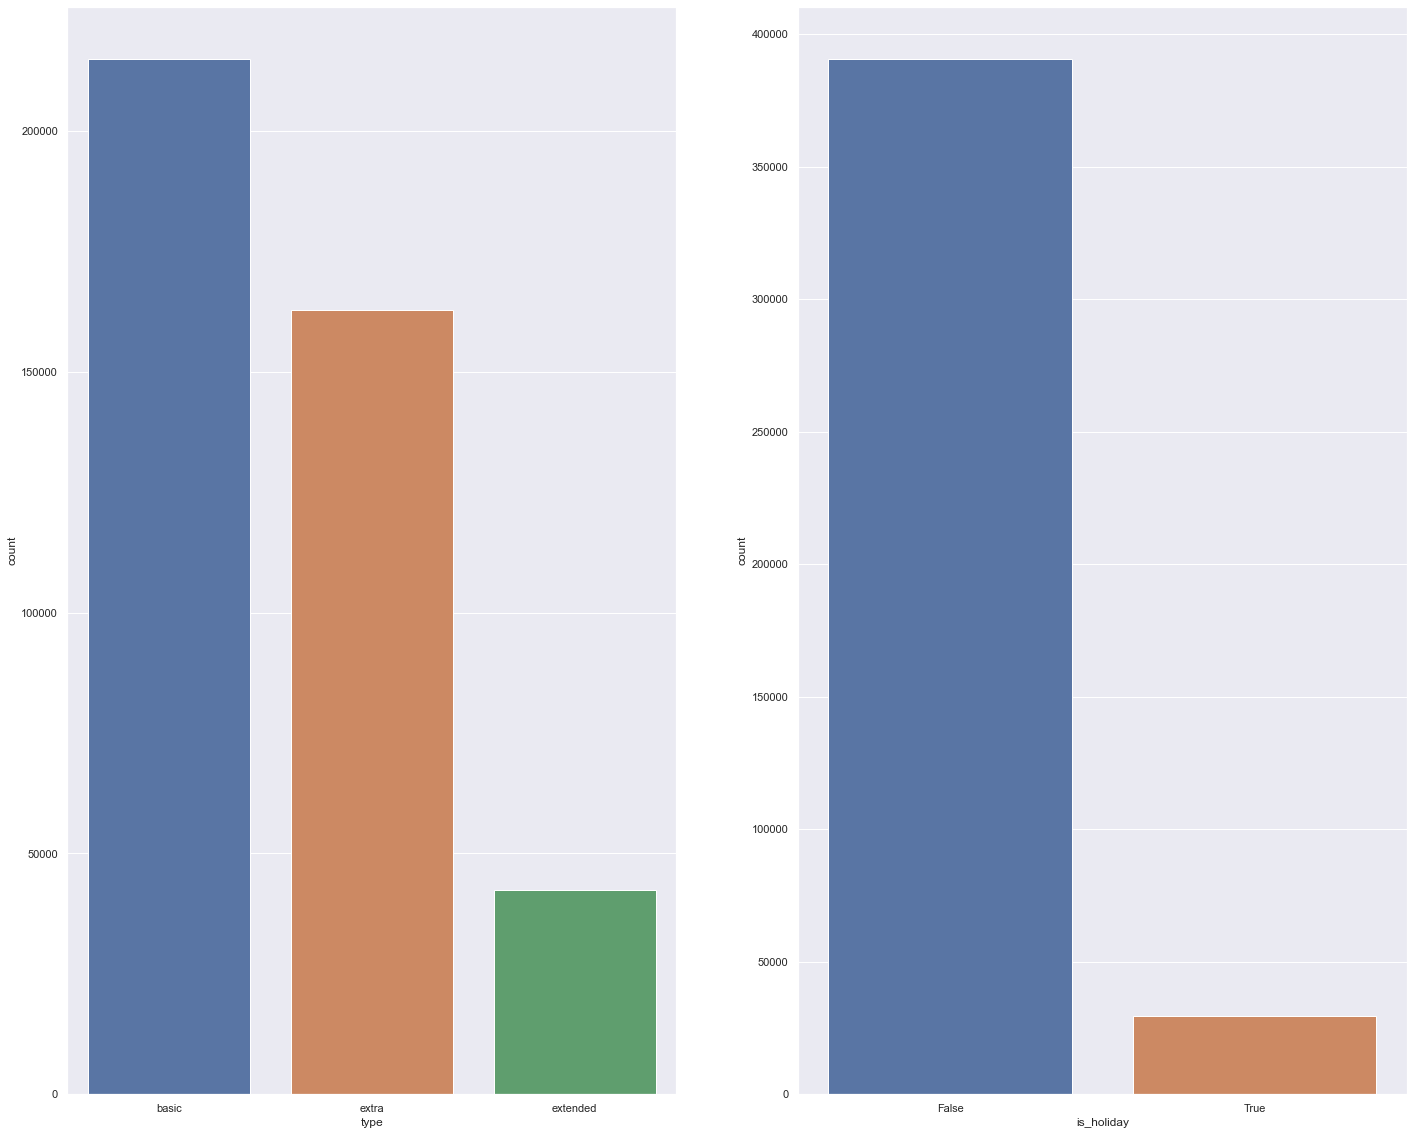

In [136]:
df4['type'].drop_duplicates()
df4['is_holiday'].drop_duplicates()

# type
plt.subplot(1,2, 1)
sns.countplot(df4['type'])

# is_holiday
plt.subplot(1,2, 2)
sns.countplot(df4['is_holiday'])

## 4.2 Analise Bivariada

### **H1.** Lojas de maior tamanho deveriam vender mais.

**VERDADEIRO** Lojas com maiores tamanho vendem mais.

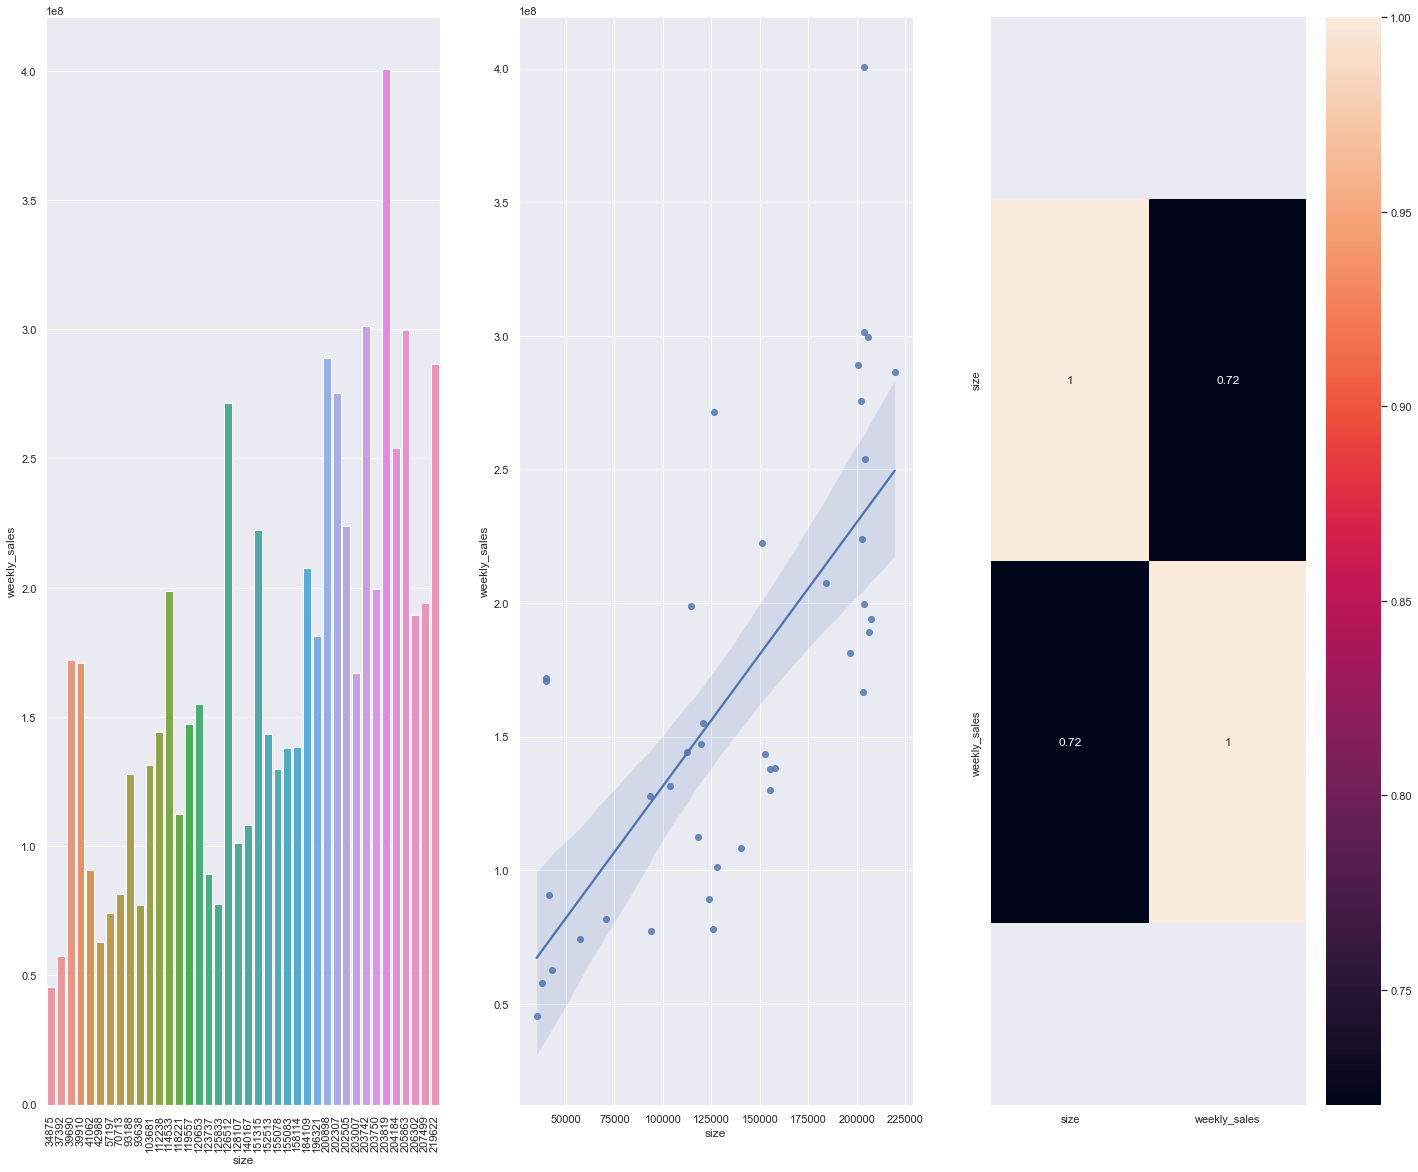

In [137]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['size', 'weekly_sales']].groupby( 'size' ).sum().reset_index()
sns.barplot( x='size', y='weekly_sales', data=aux1 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='size', y='weekly_sales', data=aux1 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);


### **H4.** Lojas deveriam vender mais no inicio do mês
**VERDADEIRA** Lojas vendem mais no inicio do mês.

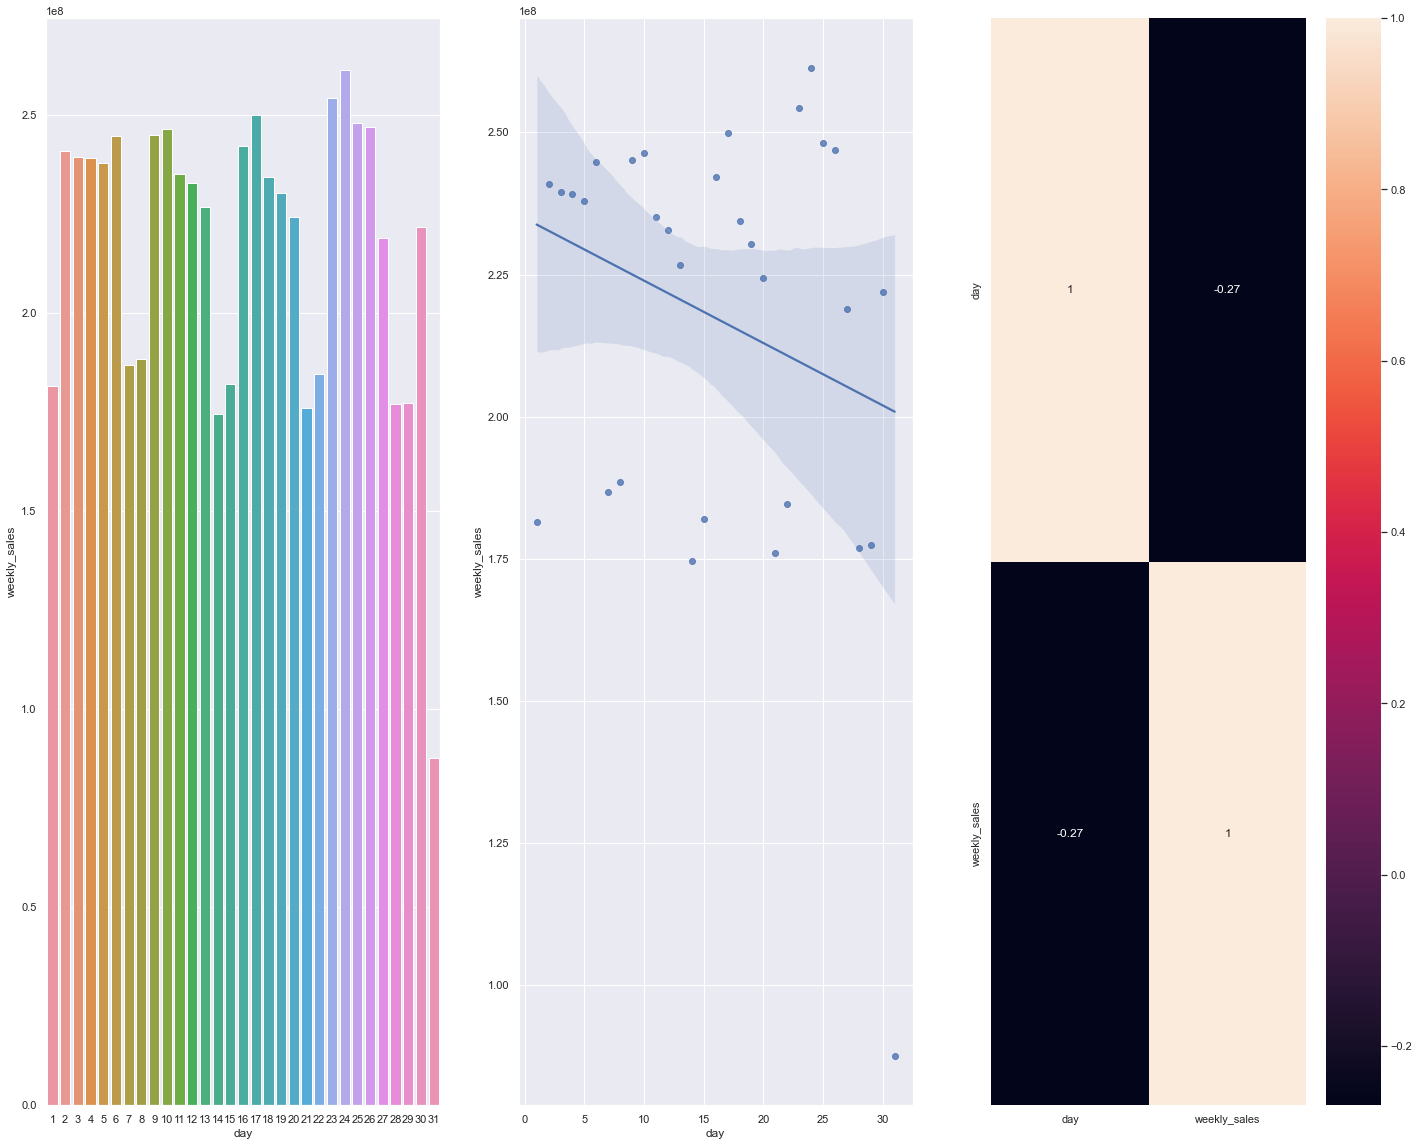

In [138]:
aux1 = df4[['day', 'weekly_sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day', y='weekly_sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day', y='weekly_sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H5.** Lojas deveriam vender menos aos feriados
**VERDADEIRO** Lojas vendem menos aos feriados. 

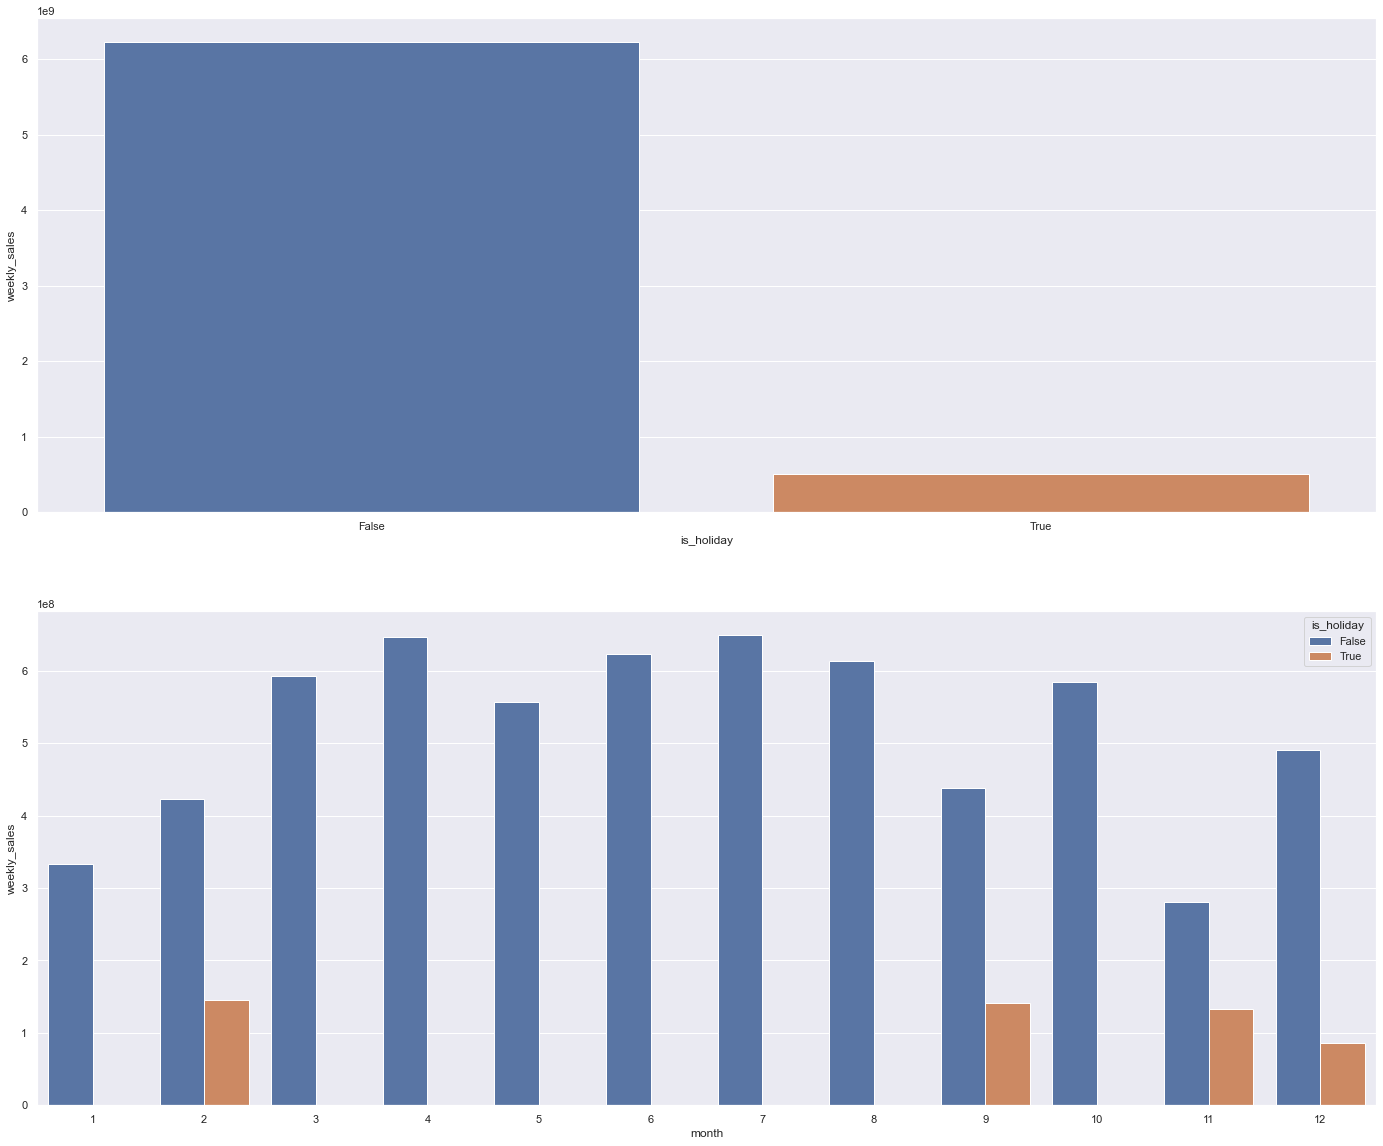

In [139]:
plt.subplot( 2, 1, 1 )
aux1 = df4[['is_holiday', 'weekly_sales']].groupby( 'is_holiday' ).sum().reset_index()
sns.barplot( x='is_holiday', y='weekly_sales', data=aux1 );

plt.subplot( 2, 1, 2 )
aux2 = df4[['is_holiday', 'weekly_sales', 'month']].groupby( ['month', 'is_holiday'] ).sum().reset_index()
sns.barplot( x='month', y='weekly_sales', hue='is_holiday',  data=aux2);

### **H6.** Lojas vendem mais no primeiro semestre do ano
**FALSA** Lojas vendem mais no segundo semestre do ano.

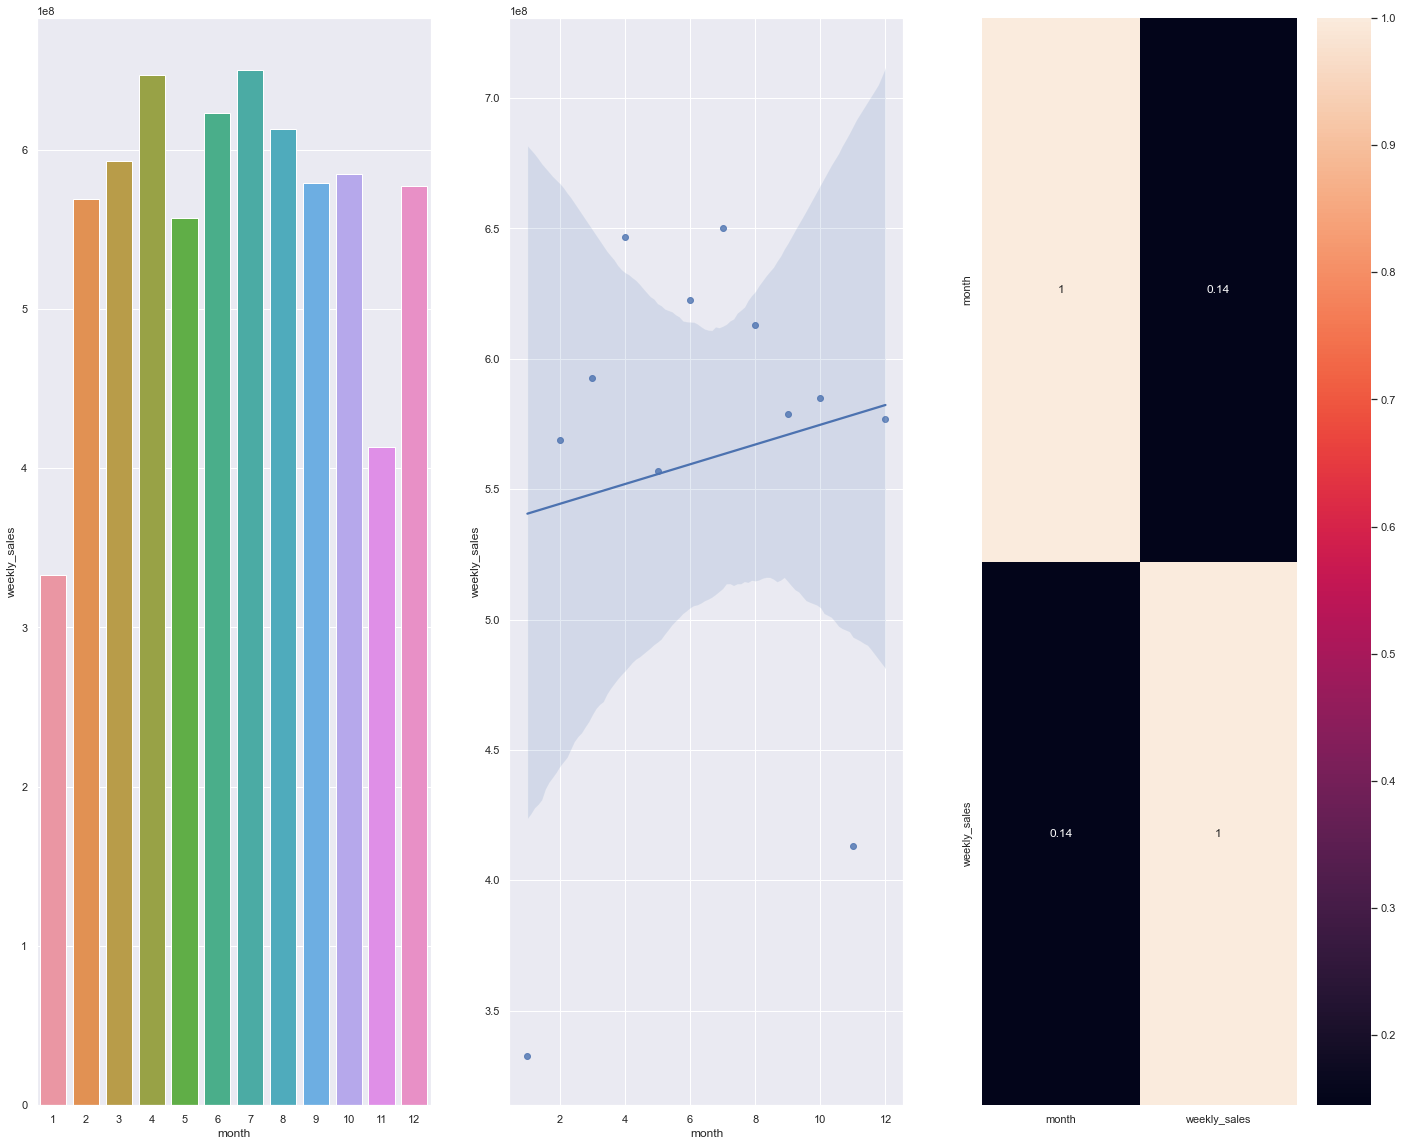

In [140]:
aux1 = df4[['month', 'weekly_sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='weekly_sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='weekly_sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H7.** Lojas deveriam vender menos quando o preço do combustivel aumenta.

**FALSO** Lojas vendem mais quando o preço do combustivel aumenta.

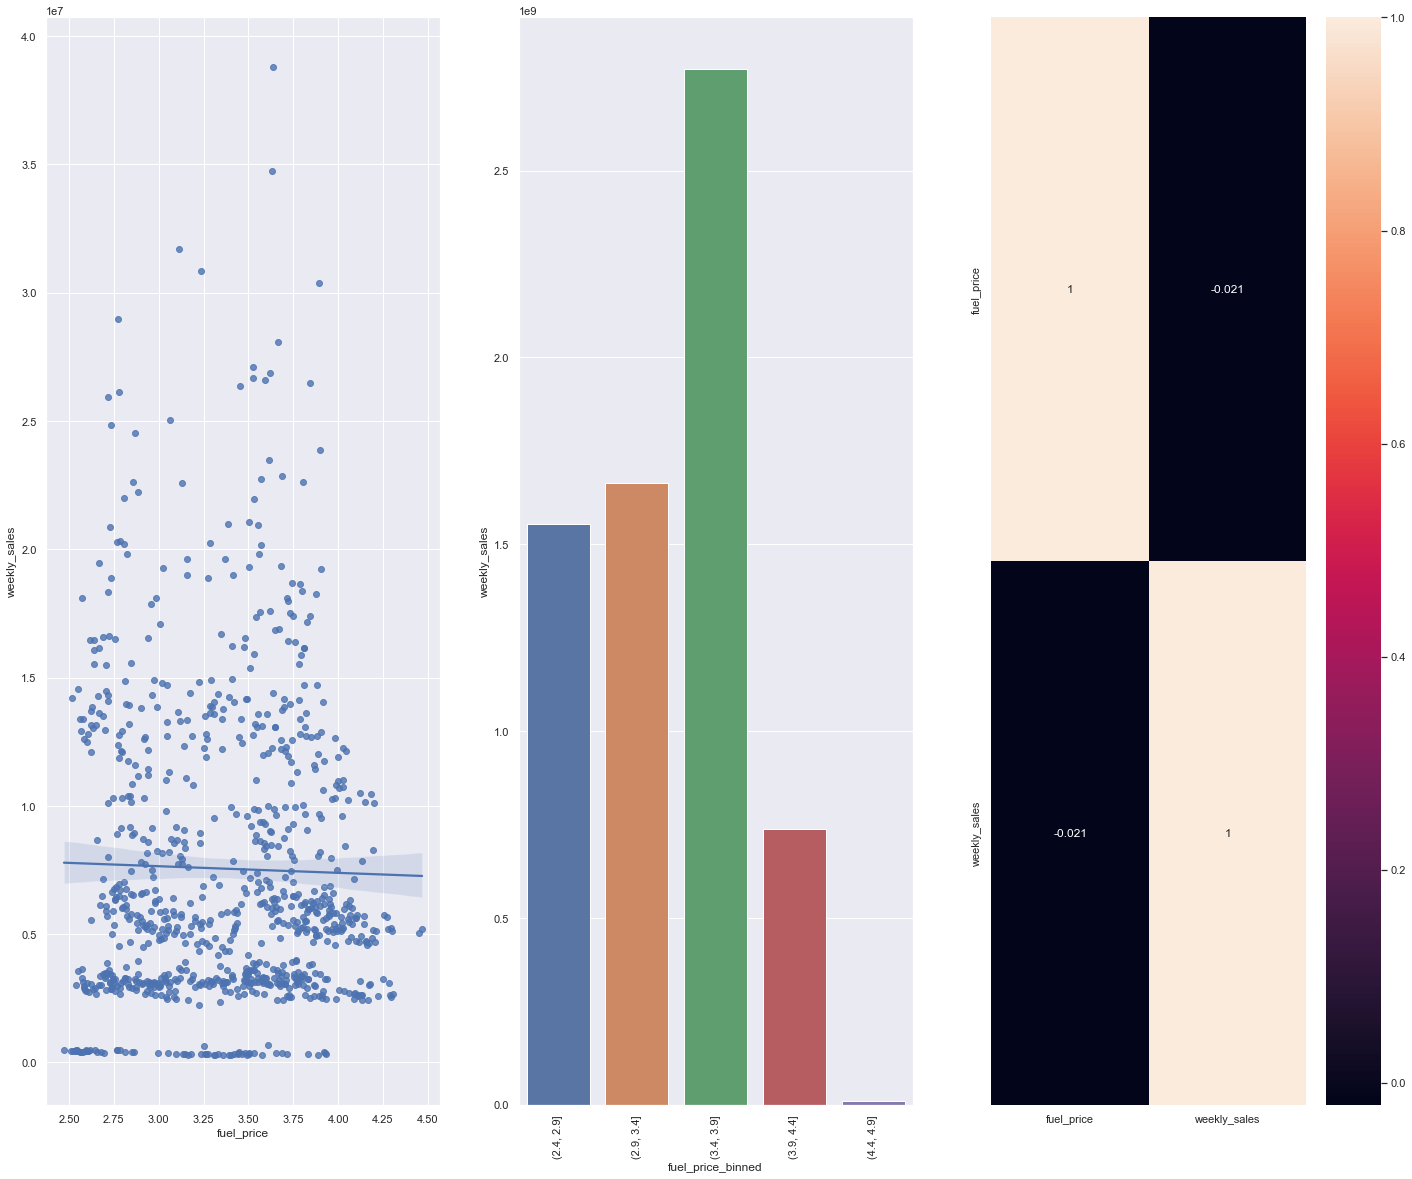

In [141]:
aux1 = df4[['fuel_price', 'weekly_sales']].groupby('fuel_price').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.regplot( x='fuel_price', y='weekly_sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 2.4, 5, 0.5) )
aux1['fuel_price_binned'] = pd.cut( aux1['fuel_price'], bins=bins )
aux2 = aux1[['fuel_price_binned', 'weekly_sales']].groupby('fuel_price_binned' ).sum().reset_index()
sns.barplot( x='fuel_price_binned', y='weekly_sales', data=aux2 ); 
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### **H8.** Lojas deveriam vender mais quando a temperatura aumenta.

**VERDADEIRA** Lojas vendem mais quando a temperatura aumenta.

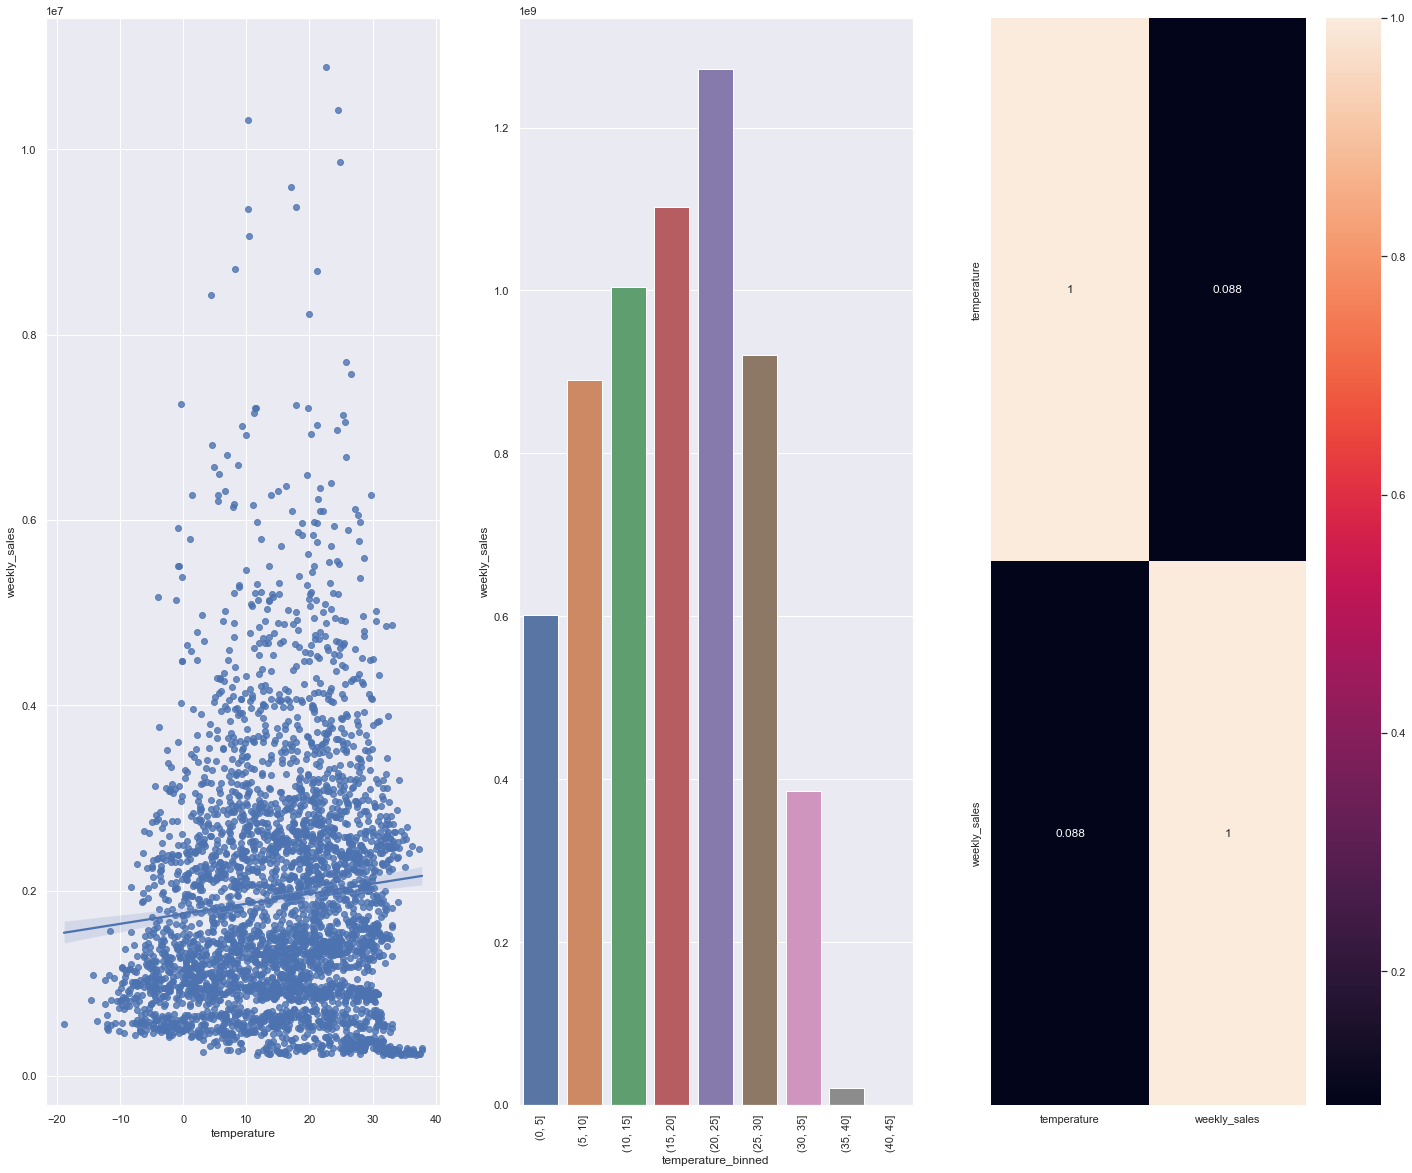

In [143]:
aux1 = df4[['temperature', 'weekly_sales']].groupby('temperature').sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.regplot( x='temperature', y='weekly_sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange(0, 50, 5) )
aux1['temperature_binned'] = pd.cut( aux1['temperature'], bins=bins )
aux2 = aux1[['temperature_binned', 'weekly_sales']].groupby('temperature_binned' ).sum().reset_index()
sns.barplot( x='temperature_binned', y='weekly_sales', data=aux2 ); 
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot:>

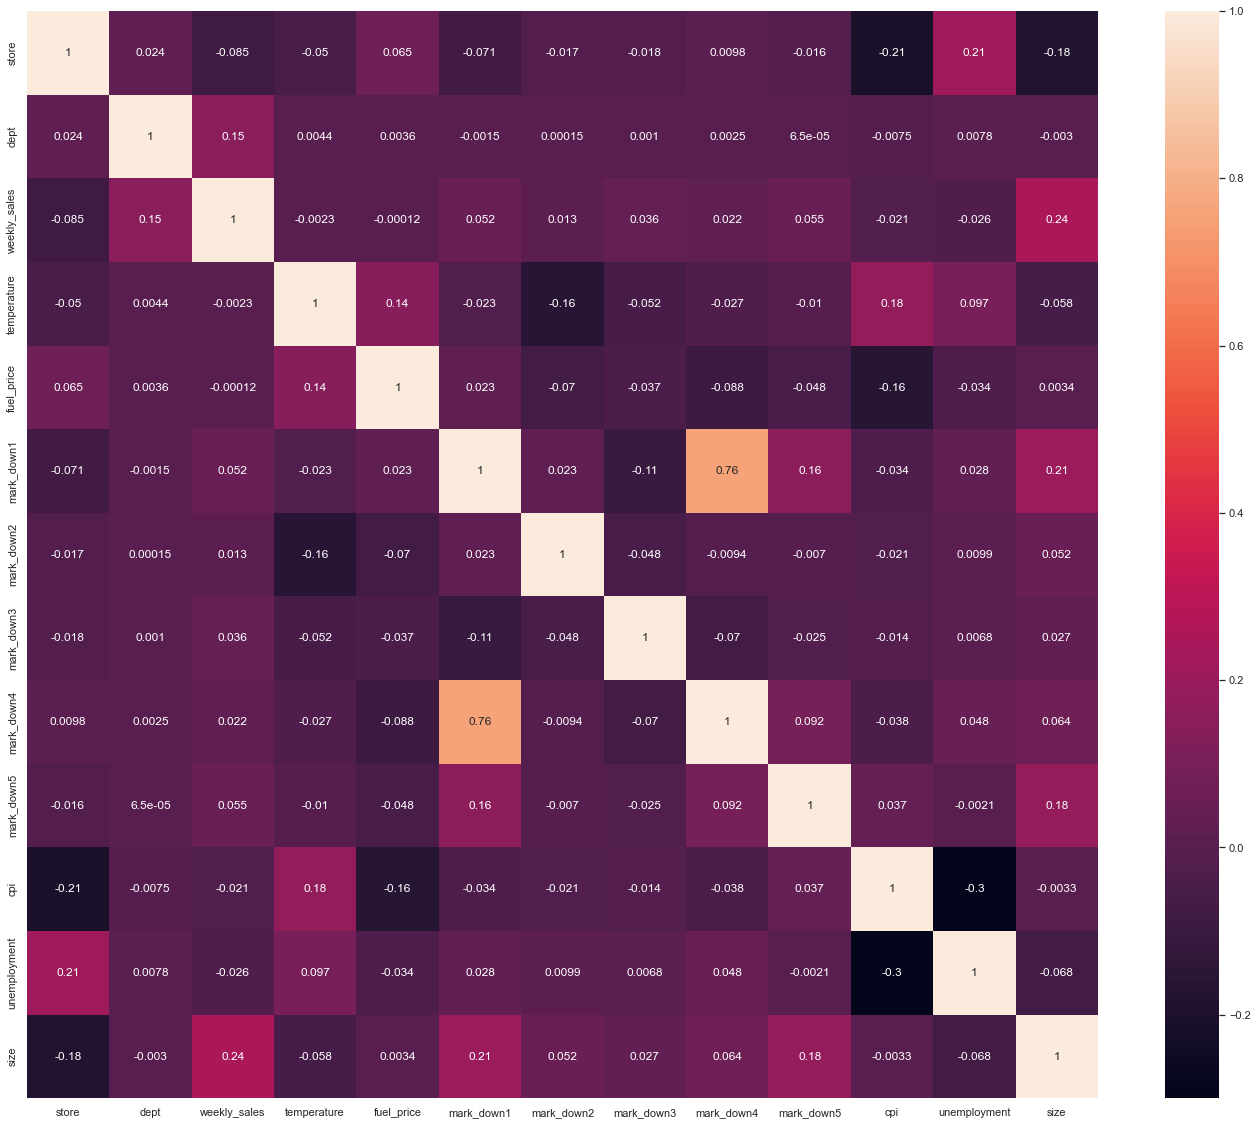

In [144]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

In [145]:
a = df4.select_dtypes(include = 'object')

<AxesSubplot:>

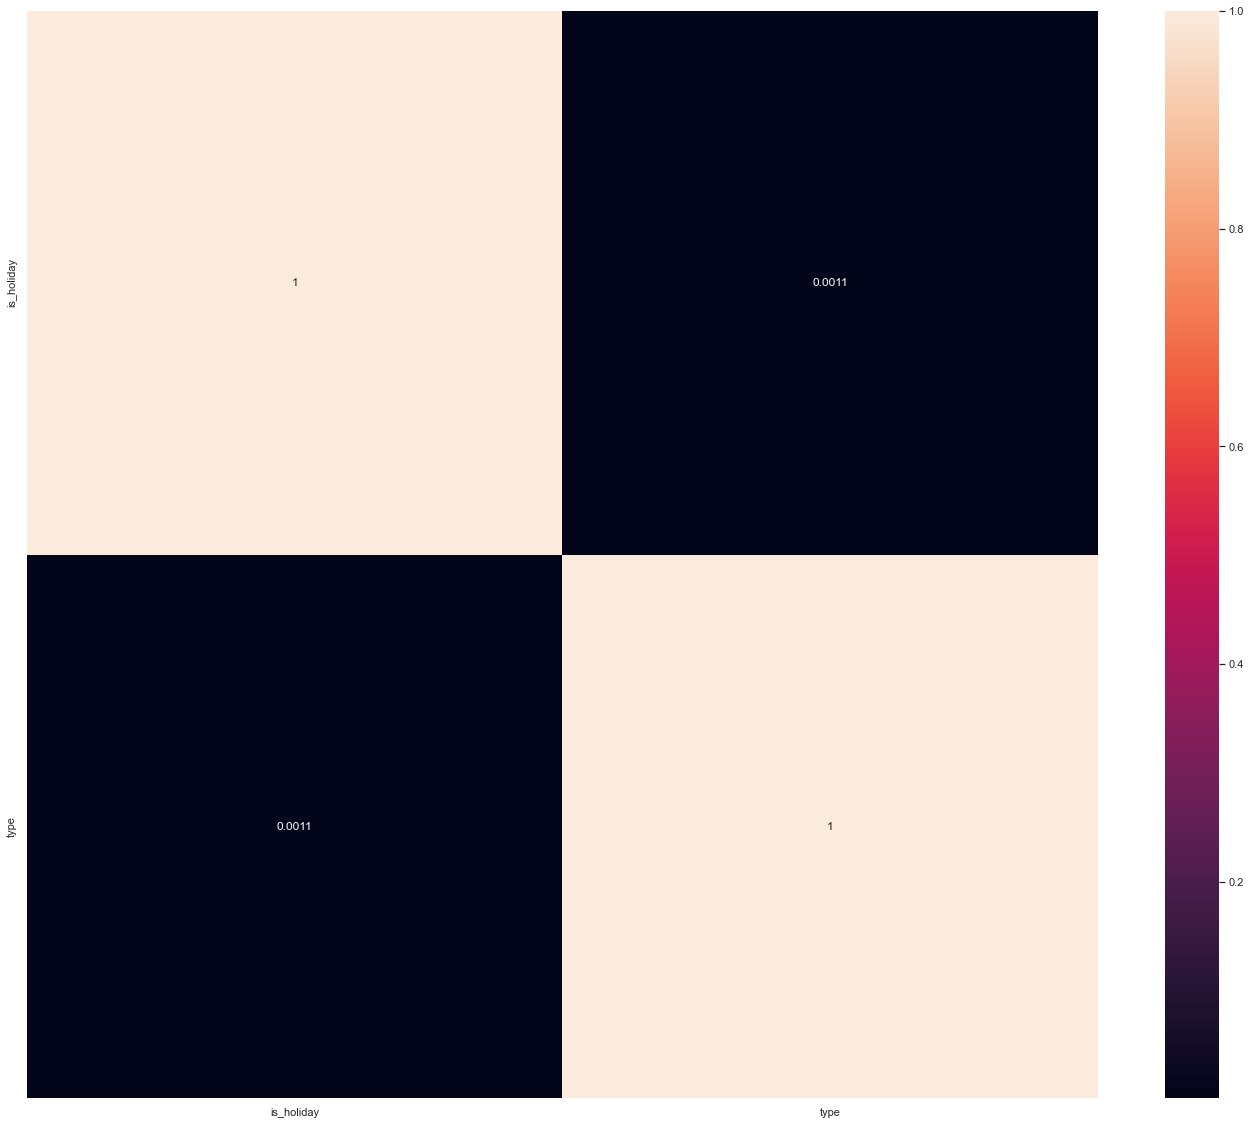

In [146]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['is_holiday'], a['is_holiday'] ) 
a2 = cramer_v( a['is_holiday'], a['type'] ) 

a3 = cramer_v( a['type'], a['is_holiday'] )
a4 = cramer_v( a['type'], a['type'] )

# Final dataset
d = pd.DataFrame( {'is_holiday': [a1, a2],
                   'type':       [a3, a4]})
d = d.set_index( d.columns ) 
sns.heatmap( d, annot=True )